# Introduction

In [5]:
import codes.VAE as VAE
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

training_batches, test_batches = VAE.VariationalAutoEncoder.get_MNIST_train_loader()

training_batches = [next(iter(training_batches))]
test_batches = [next(iter(test_batches))]

from codes.Image.ConvolutionCoders import Encoder
vaes = []
for i in [2,4,6,8,10]:
    vae = VAE.VariationalAutoEncoder(i, 0.2, convolutional = True)
    #vae.encoder = Encoder(i, 0)
    vae.set_train_loader(training_batches, test_batches)
    vaes.append((i, vae))

In [2]:
for i, vae in vaes[3:4]:
    vae.start()
    #Lets get the trained models from the disk instead
    #vae.load_state_dict(torch.load("./data/saved_models/vae_mnist_{}.pt".format(i),  map_location={'cuda:0': 'cpu'}))

started False


In [35]:
vae.get_progress()[-5:]

[(3355, 7.531985759735107, 71.16197967529297),
 (3356, 6.264549255371094, 70.69050598144531),
 (3357, 6.321658611297607, 67.76502227783203),
 (3358, 9.173351287841797, 68.64701080322266),
 (3359, 6.408588886260986, 70.79420471191406)]

<IPython.core.display.Javascript object>


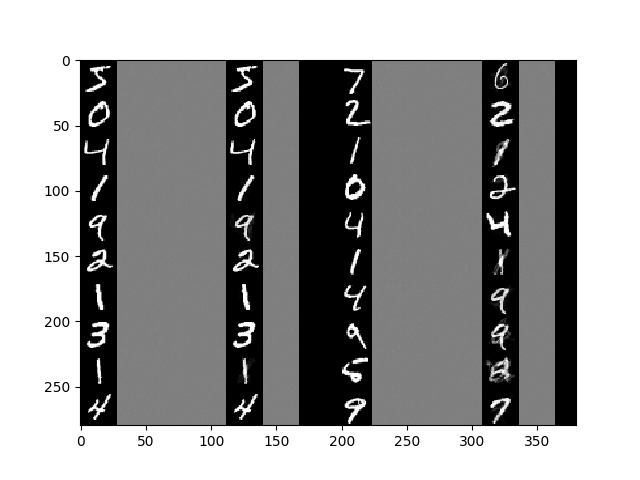

In [34]:
import matplotlib.pyplot as plt
import numpy
%matplotlib notebook

training_batch = next(iter(training_batches))
test_batch = next(iter(test_batches))

im = numpy.zeros((280,380))
for i in range(10):
    im[i*28:i*28+28,0:28] = Variable((training_batch))[i,0].data
    for j in range(5):
        im[i*28:i*28+28,(j+1)*28:(j+1)*28+28] = vaes[j][1](Variable((training_batch[i:i+1])))[0].data

for i in range(10):
    im[i*28:i*28+28,7*28:7*28+28] = Variable((test_batch))[i,0].data
    for j in range(5):
        im[i*28:i*28+28,(j+8)*28:(j+8)*28+28] = vaes[j][1](Variable((test_batch[i:i+1])))[0].data
        
plt.imshow(im, cmap="gray")

In [ ]:
import torch
from torchvision import datasets, transforms
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

In [ ]:
points = []
for data, labels in list(train_loader)[0:15]:
    s = vaes[0][1].encoder(Variable(data))
    for  point, label in zip(s[1].data.numpy(), labels):
        points.append((point, label))

In [ ]:
import pandas
df = pandas.DataFrame(points, columns=["point","label"])

In [ ]:
import matplotlib.pyplot as plt
import numpy
%matplotlib notebook
plt.xlim(-5,5)
colors = ["green","yellow","blue","orange","gray","red","black","purple","pink","brown"]
groups = df.groupby("label")
for key, group in groups:
    x=group["point"].apply(lambda x: x[0])
    y=group["point"].apply(lambda x: x[1])
    plt.plot(x,y,"o", color=colors[key])

In [90]:
from sklearn.metrics import silhouette_score
silhouette_score(numpy.array([list(point) for point in (df["point"])]), numpy.array(df["label"]))

0.1487785

In [11]:
from codes.utility.Misc import get_number_of_parameters

In [12]:
get_number_of_parameters(vae)

488073

In [23]:
40//3

13

# Classification

In [97]:
import codes.VAE as VAE
import torch, numpy
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

training_batches, test_batches = VAE.VariationalAutoEncoder.get_FashionMNIST_train_loader(
    keep_classes=True)

training_batches = [next(iter(training_batches))]
test_batches = [next(iter(test_batches))]

vae = VAE.VariationalAutoEncoder(10, 0.0, convolutional = True)
vae.set_train_loader(training_batches, test_batches)
vae.load_state_dict(torch.load("./data/saved_models/checkpoint_740.pt",  map_location={'cuda:0': 'cpu'}))
#vaes = []
#for i in [2,4,6,8,10]:
#    vae = VAE.VariationalAutoEncoder(i, 0.2, convolutional = True)
#    #vae.encoder = Encoder(i, 0)
#    vae.set_train_loader(training_batches, test_batches)
#    vaes.append((i, vae))

In [10]:
def loss_function(_in, _out, mu, log_std, _class):
        img_loss =  _in.sub(_out).pow(2).sum()
        mean_sq = mu * mu
        latent_loss = -0.5 * torch.sum(1.0 + 2.0 * log_std - mean_sq - torch.exp(2.0 * log_std))
        latent_loss += torch.sum((mu[:,-1]-Variable((_clasus==0).float()*2-1))**2)
        return img_loss + latent_loss, img_loss, latent_loss
    

def train(model, train_loader, test_loader, counter_epoch,
                  counter_iterations, loss_queue, stop_signal):
            print("started", stop_signal.value)
            train_op = optim.Adam(model.parameters(), lr=0.0005)
            while not stop_signal.value:
                loss_train = []
                loss_test = []
                n_train = []
                n_test = []
                for _, (data, _class) in enumerate(train_loader):
                    # data = Variable(data.view(-1,784))
                    data = Variable(data)
                    train_op.zero_grad()
                    dec = model(data)
                    loss, loss_1, loss_2 = loss_function(dec, data, model.mu, model.log_std, _class)
                    loss_train.append((loss.data[0], loss_1.data[0], loss_2.data[0]))
                    n_train.append(len(data))
                    loss.backward()
                    train_op.step()
                    counter_iterations.increment()

                #for _, data, _class in enumerate(test_loader):
                #    # data = Variable(data.view(-1,784))
                #    data = Variable(data)
                #    dec = model(data)
                #    loss, _, _ = model.loss(dec, data, model.mu, model.log_std)
                #    loss_test.append(loss.data[0])
                #    n_test.append(len(data))

                counter_epoch.increment()

                epoch = counter_epoch.value
                loss_train_mean = numpy.mean(loss_train, axis = 0)# / numpy.sum(n_train)
                #loss_test_mean = numpy.mean(loss_test)# / numpy.sum(n_test)
                loss_queue.put((epoch, loss_train_mean))

In [51]:
vae.start(train)

started False


In [52]:
vae.get_progress()[-5:]

[]

In [99]:
vae(Variable(test_batches[0][0]))
list(zip(numpy.argmax(vae.mu[:,-10:].data.numpy(), axis=1), test_batches[0][1].numpy()))

[(9, 9),
 (2, 2),
 (1, 1),
 (1, 1),
 (6, 6),
 (1, 1),
 (4, 4),
 (6, 6),
 (5, 5),
 (7, 7),
 (4, 4),
 (5, 5),
 (5, 7),
 (3, 3),
 (4, 4),
 (1, 1),
 (2, 2),
 (4, 4),
 (8, 8),
 (0, 0),
 (2, 2),
 (7, 5),
 (7, 7),
 (5, 9),
 (1, 1),
 (2, 4),
 (6, 6),
 (0, 0),
 (9, 9),
 (3, 3),
 (8, 8),
 (8, 8)]

<IPython.core.display.Javascript object>


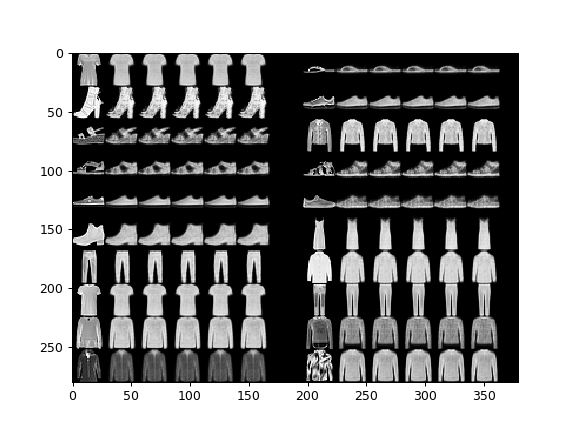

In [101]:
import matplotlib.pyplot as plt
import numpy
%matplotlib notebook

training_batch = next(iter(training_batches))
test_batch = next(iter(test_batches))

im = numpy.zeros((280,380))
for i in range(10):
    im[i*28:i*28+28,0:28] = Variable((training_batch)[0])[i+10,0].data
    for j in range(5):
        l = vae.encoder(Variable(training_batch[0][i+10:i+10+1]))[1]
        o = vae.decoder(l)
        im[i*28:i*28+28,(j+1)*28:(j+1)*28+28] = o[0].data

for i in range(10):
    im[i*28:i*28+28,7*28:7*28+28] = Variable((test_batch[0]))[i+8,0].data
    for j in range(5):
        l = vae.encoder(Variable(test_batch[0][i+8:i+1+8]))[1]
        o = vae.decoder(l)
        im[i*28:i*28+28,(j+8)*28:(j+8)*28+28] = o[0].data
        
plt.imshow(im, cmap="gray")